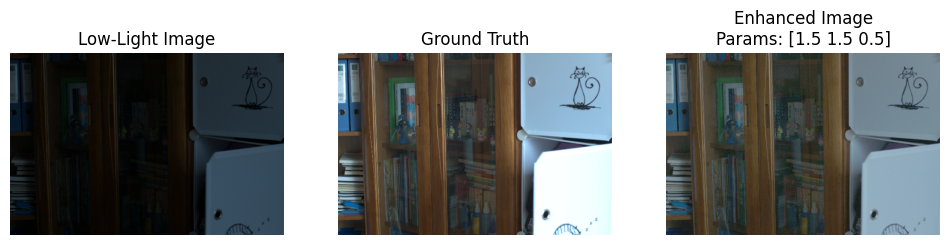

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Particle class for PSO
class Particle:
    def __init__(self, s):
        """Initialize a particle with random brightness, contrast, and gamma values."""
        self.pos = np.random.uniform(0.5, s, 3)  # [brightness, contrast, gamma]
        self.vel = np.random.uniform(-1, 1, 3)   # Velocity in 3D search space
        self.pBest = self.pos.copy()             # Best parameters found so far

    def updateVel(self, w, c1, c2, gBest):
        inertial = w * self.vel
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive = r1 * c1 * (self.pBest - self.pos)
        social = r2 * c2 * (gBest - self.pos)
        self.vel = inertial + cognitive + social

    def updatePos(self, s):
        self.pos += self.vel
        self.pos = np.clip(self.pos, 0.5, s)

# Image enhancement using given parameters
def enhance_image(image, params):
    brightness, contrast, gamma = params
    enhanced = np.zeros_like(image, dtype=np.uint8)  # FIX: set dtype to uint8

    for c in range(3):  # For R, G, B channels
        # Apply contrast and brightness
        temp = cv2.convertScaleAbs(image[:, :, c], alpha=contrast, beta=brightness)
        temp = np.clip(temp, 1, 255)

        # Gamma correction (must be done in float)
        gamma_corrected = np.power(temp.astype(np.float32) / 255.0, gamma) * 255.0

        # Final cast back to uint8
        enhanced[:, :, c] = np.uint8(np.clip(gamma_corrected, 0, 255))

    return enhanced


def fit(image, gt, params):
    enhanced = enhance_image(image, params)
    psnr_val = psnr(gt, enhanced)

    try:
        ssim_val = ssim(gt, enhanced, data_range=255, channel_axis=2)
    except ValueError as e:
        print(f"SSIM Error: {e}. Using only PSNR.")
        ssim_val = 0

    return -(psnr_val + ssim_val)


# Main PSO routine
def pso(image, gt, s=1.5, n=20, maxIter=50, w=0.7, c1=1.5, c2=1.5):
    swarm = [Particle(s) for _ in range(n)]
    gBest = min(swarm, key=lambda p: fit(image, gt, p.pBest)).pBest.copy()

    for _ in range(maxIter):
        for particle in swarm:
            if fit(image, gt, particle.pos) < fit(image, gt, particle.pBest):
                particle.pBest = particle.pos.copy()
            if fit(image, gt, particle.pos) < fit(image, gt, gBest):
                gBest = particle.pos.copy()

        for particle in swarm:
            particle.updateVel(w, c1, c2, gBest)
            particle.updatePos(s)

    return gBest

# Load and prepare your own images in Colab
# Upload images first using:
# from google.colab import files
# files.upload()

image = cv2.imread("/content/drive/MyDrive/LOL_Dataset_btp_6th_sem/low/2.png")
gt = cv2.imread("/content/drive/MyDrive/LOL_Dataset_btp_6th_sem/high/2.png")

# Convert to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

# Resize if too small
if image.shape[0] < 7 or image.shape[1] < 7:
    print(" Image too small for SSIM. Resizing to 128x128.")
    image = cv2.resize(image, (128, 128))
    gt = cv2.resize(gt, (128, 128))

# Run PSO and show result
best_params = pso(image, gt)
enhanced_image = enhance_image(image, best_params)

# Show output
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Low-Light Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gt)
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(enhanced_image)
plt.title(f"Enhanced Image\nParams: {best_params}")
plt.axis("off")

plt.show()


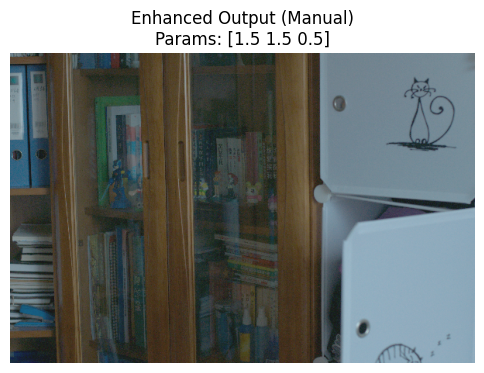

In [ ]:
# Apply best PSO parameters manually to low-light image
enhanced_image = enhance_image(image, best_params).astype(np.uint8)


# Show only enhanced image
plt.figure(figsize=(6, 6))
plt.imshow(enhanced_image)
plt.title(f"Enhanced Output (Manual)\nParams: {best_params}")
plt.axis("off")
plt.show()
